In [1]:
!pip install pytorch-ignite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# %% Import and stuff
import torch
from torch import nn
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import time
import random
import torchvision.utils as vutils
from  torch.utils import data
from mpl_toolkits.axes_grid1 import ImageGrid
from ignite.metrics import FID

from ignite.engine import *
from ignite.handlers import *
from ignite.metrics import *
from ignite.utils import *
from ignite.contrib.metrics.regression import *
from ignite.contrib.metrics import *
from collections import OrderedDict



NUM_EPOCHS = 10
LR = 0.0002
LATENT_DIM = 100
IMG_SIZE = 28
CHANNELS = 1
B1 = 0.5
B2 = 0.999


GEN_STATE_DICT = "gen_state_dict"
DISC_STATE_DICT = "disc_state_dict"
GEN_OPTIMIZER = "gen_optimizer"
DISC_OPTIMIZER = "disc_optimizer"
G_LOSSES = "g_losses"
D_LOSSES = "d_losses"



SHUFFLE = True
PIN_MEMORY = True
NUM_WORKERS = 0
BATCH_SIZE = 2500

specific_latent = torch.tensor([[0.7628, 0.1779, 0.3978, 0.3606, 0.6387,
         0.3044, 0.8340, 0.3884, 0.9313, 0.5635, 0.1994, 0.6934, 0.5326,
         0.3676, 0.5342, 0.9480, 0.4120, 0.5845, 0.4035, 0.5298, 0.0177,
         0.5605, 0.6453, 0.9576, 0.7153, 0.1923, 0.8122, 0.0937, 0.5744,
         0.5951, 0.8890, 0.4838, 0.5707, 0.6760, 0.3738, 0.2796, 0.1549,
         0.8220, 0.2800, 0.4051, 0.2553, 0.1831, 0.0046, 0.9021, 0.0264,
         0.2327, 0.8261, 0.0534, 0.1582, 0.4087, 0.9047, 0.1409, 0.6864,
         0.1439, 0.3432, 0.1072, 0.5907, 0.6756, 0.6942, 0.6814, 0.3368,
         0.4138, 0.8030, 0.7024, 0.3309, 0.7288, 0.2193, 0.1954, 0.9948,
         0.1201, 0.9483, 0.7407, 0.4849, 0.6500, 0.8649, 0.7405, 0.4725,
         0.5373, 0.6541, 0.5444, 0.7425, 0.8940, 0.3580, 0.3905, 0.8924,
         0.2995, 0.3726, 0.5399, 0.3057, 0.3380, 0.8313, 0.1137, 0.0120,
         0.7714, 0.2561, 0.2569, 0.2994, 0.7648, 0.2413, 0.6101
        ]])


img_shape = (CHANNELS, IMG_SIZE, IMG_SIZE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:{}'.format(device))


Device:cuda


In [3]:
# %% helper funcitons


def save_checkpoint(state, filename):
    print("=> Saving chekpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint):
    generator.load_state_dict(checkpoint[GEN_STATE_DICT])
    optimizer_G.load_state_dict(checkpoint[GEN_OPTIMIZER])
    discriminator.load_state_dict(checkpoint[DISC_STATE_DICT])
    optimizer_D.load_state_dict(checkpoint[DISC_OPTIMIZER])
    G_losses = checkpoint[G_LOSSES]
    D_losses = checkpoint[D_LOSSES]
    


# takes input tensor and return a tensor of same size but every element has different value
def build_fake_labels(old_list):
  
    new_list = []

    for i, x in enumerate(old_list):

        if (i % 10) != x:
            new_list.append(i % 10)
        else:
            new_list.append((x.item()+1) % 10)

    return torch.tensor(new_list, dtype=torch.int64).to(device)


def add_noise(inputs, variance):
    noise = torch.randn_like(inputs)
    return inputs + variance*noise

def gen_image(caption=-1,randomLatent=True):
    generator.to('cpu')
    discriminator.to('cpu')

    with torch.no_grad():
        for image,_ in train_loader:
            f, axarr = plt.subplots(1)
            
            if randomLatent:
                latent = torch.rand_like(torch.Tensor(1,100))
            else:
                latent = specific_latent
                
            if caption == -1:
                caption = random.randint(0, 9)
            
            caption = torch.tensor(caption, dtype=torch.int64)
            fake_image = generator(latent,caption)  
           
            
            #axarr.imshow(add_noise(image[0][0],0.5))    
            axarr.imshow(fake_image[0][0])   
            print("Supposed to be %d" %caption.item())
    
            break
        
def discriminate_image(caption=-1,genOrReal=0):#random.randint(0, 1)):
    generator.to('cpu')
    discriminator.to('cpu')
    
    with torch.no_grad():
        for  i, (imgs, labels) in enumerate(example_loader):
            f, axarr = plt.subplots(1)
            
            fake_labels = build_fake_labels(labels.to(device))
            labels = labels.to('cpu')
            z = Variable(Tensor(np.random.normal(0, 1, (1,LATENT_DIM)))).cpu()
            if caption == -1:
                caption = random.randint(0, 9)
            caption = torch.tensor(caption, dtype=torch.int64)
            
            
            #feed discriminator fake image, expect "0" output
            if genOrReal == 0:
                fake_image = generator(z,caption)
                axarr.imshow(fake_image[0].reshape(-1, 28, 28)[0])
                pred = discriminator(fake_image,caption).detach()
                print("Discriminator Prediction: {},Should be: {}, label = {}".format(pred,"0",caption))
            #feed discriminator real image, expect "1" output
            else:
                fake_image = generator(z,labels[0])
                axarr.imshow(imgs[0].reshape(-1, 28, 28)[0])
                pred = discriminator(imgs.detach(),labels[0].detach()).detach()
                print("Discriminator Prediction: {},Should be: {}, label= {}".format(pred,"1",labels[0]+1))
            
    
            break

In [4]:
# %%train data

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
    ])


train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = data.DataLoader(
                                train_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=False,
                                num_workers=NUM_WORKERS,
                                pin_memory=False
                                )

test_loader = data.DataLoader(
                                test_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=True,
                                pin_memory=False
                                )

example_loader = data.DataLoader(
                                train_dataset,
                                batch_size=1,
                                shuffle=True,
                                num_workers=0,
                                drop_last=True,
                                )


In [5]:
# %% Detective: fake or no fake -> 1 output [0, 1]
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(2, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)

        self.emb = nn.Embedding(10, 50)
        self.emb_fc = nn.Linear(50, 784)

        self.nconv1 = nn.Conv2d(2, 64, kernel_size=5)
        self.nconv2 = nn.Conv2d(64, 128, kernel_size=5)
        self.pool = nn.AvgPool2d(kernel_size=3)
        self.pool2 = nn.AvgPool2d(kernel_size=2)
        self.nfc1 = nn.Linear(1152, 164)
        self.nfc2 = nn.Linear(164, 1)

    # oldWay flag to select between 2 train methods, not sure which is best yet
    def forward(self, x, c, oldWay=False):

        c = self.emb(c)
        c = self.emb_fc(c)
        c = c.view(-1, 1, 28, 28)
        x = torch.cat((c, x), 1)  # concat image[1,28,28] with text [1,28,28]

        x = F.leaky_relu(self.nconv1(x))
        x = F.leaky_relu(self.nconv2(x))
        x = self.pool(x)
        x = self.pool2(x)
        x = x.view(-1, 1152)
        x = F.leaky_relu(self.nfc1(x))
        x = F.dropout(x, training=self.training)
        x = self.nfc2(x)

        x = torch.sigmoid(x)
        return x


# %% Generate Fake Data: output like real data [1, 28, 28] and values -1, 1
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(LATENT_DIM, 7*7*63)  # [n,100]->[n,3087]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2)  # [n, 64, 16, 16] [32,..,..]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2)  # [n, 32, , ]->[n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 16, 34, 34]-> [n, 1, 28, 28]
        
        self.emb = nn.Embedding(10, 50) 
        self.label_lin = nn.Linear(50, 49)
        self.conv_x_c = nn.ConvTranspose2d(65, 64, 4, stride=2)  # upsample [65,7,7] -> [64,14,14]
        self.tanh = nn.Tanh()

    def forward(self, x, c):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)  # (n,100) -> (n,3187)
        x = F.leaky_relu(x)
        x = x.view(-1, 63, 7, 7)  # (n,3187) -> (63,7,7)
        
        #Encode label
        c = self.emb(c)  # (n,) -> (n,50)
        c = self.label_lin(c)  # (n,50) -> (n,49)
        c = c.view(-1, 1, 7, 7)  # (n,49) -> (n,1,7,7)
        x = torch.cat((c, x), 1) # concat image[63,7,7] with text [1,7,7]

        x = self.ct1(x)  # [n, 64, 16, 16] [32,34,34]
        x = F.leaky_relu(x)

        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.leaky_relu(x)

        # Convolution to 28x28 (1 feature map)
        x = self.tanh(self.conv(x))
        return x

In [12]:
#%% Loss fucntion, optimizers
loss_func = nn.BCELoss()
recon_loss = nn.MSELoss()

# Initialize generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()
    loss_func.cuda()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=LR,betas=(B1 ,B2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=LR,betas=(B1 ,B2))

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [13]:
#%% Train both models
if torch.cuda.is_available():
    generator.to(device)
    discriminator.to(device)
    loss_func.to(device)


NUM_EPOCHS = 10

#--Discriminator
D_losses = []
fake_losses = []
real_losses = []


#--Generator
G_losses = []
bce_losses = []
#mse_losses = []


if __name__ == '__main__':
    for epoch in range(NUM_EPOCHS):
      for i, (imgs, labels) in enumerate(train_loader):
        

        # -----------------
        # Things to use later
        # -----------------
        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)
        
        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0],LATENT_DIM))))

        # transform to tensor [batch_size,1,28,28]
        real_imgs = Variable(imgs.type(Tensor)).to(device)
        #fake_labels = build_fake_labels(labels.to(device))
        
        labels = labels.to(device)
        
        # -----------------
        # Train discriminator
        # -----------------
        optimizer_D.zero_grad()
        
        #Discriminate real_images
        real_pred = discriminator(real_imgs,labels)
        real_loss = loss_func(real_pred,valid)

        # Generate a batch of fake images
        fake_imgs = generator(z,labels)
        
        # Calculate D's loss on the all-fake batch
        fake_pred = discriminator(fake_imgs.detach(),labels.detach())
        fake_loss = loss_func(fake_pred, fake)
        
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        fake_loss = fake_loss.mean().item()
        real_loss = real_loss.mean().item()

        
        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()
        
        #Calculate recon loss and bce loss            
        fake_imgs = generator(z,labels)
        fake_pred = discriminator(fake_imgs,labels)

        #mse_loss  = recon_loss(fake_imgs,real_imgs)
        bce_loss = loss_func(fake_pred,valid)
    
        #Overall loss
        g_loss = bce_loss
        g_loss.backward()
        optimizer_G.step()

        bce_loss = bce_loss.mean().item()
        #mse_loss = mse_loss.mean().item()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d] Loss_D: %.4f\tLoss_G: %.4f (%.4f)fake_pred: %.4f real_pred: %.4f'
                  % (epoch, NUM_EPOCHS, d_loss.item(), g_loss, bce_loss, fake_loss, real_loss  ))

        # Save Losses for plotting later
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())
        bce_losses.append(bce_loss)
        #mse_losses.append(mse_loss)
        
        fake_losses.append(fake_loss)
        real_losses.append(real_loss)


      

[0/10] Loss_D: 1.3914	Loss_G: 0.7039 (0.7039)fake_pred: 0.6746 real_pred: 0.7167
[1/10] Loss_D: 0.2336	Loss_G: 2.6156 (2.6156)fake_pred: 0.1249 real_pred: 0.1088
[2/10] Loss_D: 0.0179	Loss_G: 4.6860 (4.6860)fake_pred: 0.0123 real_pred: 0.0057
[3/10] Loss_D: 0.0459	Loss_G: 4.2979 (4.2979)fake_pred: 0.0193 real_pred: 0.0266
[4/10] Loss_D: 0.3342	Loss_G: 2.6807 (2.6807)fake_pred: 0.1539 real_pred: 0.1803
[5/10] Loss_D: 0.4333	Loss_G: 1.0471 (1.0471)fake_pred: 0.0419 real_pred: 0.3914
[6/10] Loss_D: 0.3828	Loss_G: 1.8632 (1.8632)fake_pred: 0.1205 real_pred: 0.2623
[7/10] Loss_D: 0.3512	Loss_G: 2.3031 (2.3031)fake_pred: 0.1325 real_pred: 0.2186
[8/10] Loss_D: 0.3948	Loss_G: 2.6634 (2.6634)fake_pred: 0.1731 real_pred: 0.2217
[9/10] Loss_D: 0.4574	Loss_G: 2.5576 (2.5576)fake_pred: 0.1862 real_pred: 0.2712


Supposed to be 4


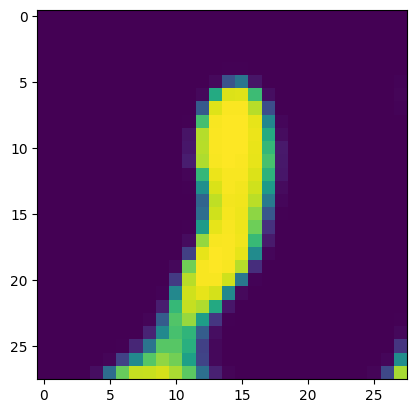

In [15]:
gen_image()

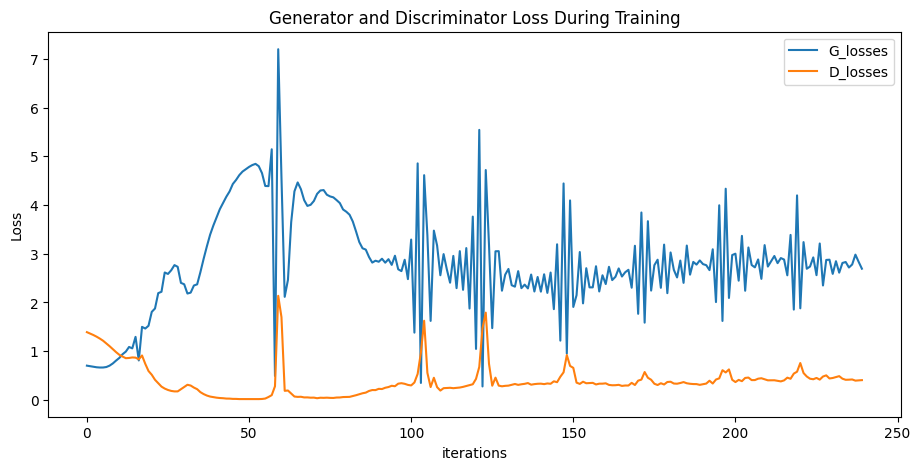

In [16]:
# %%Plot Losses

plt.figure(figsize=(11,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses[:], label="G_losses")
plt.plot(D_losses[:], label="D_losses")
#plt.plot(sampled_list[:], label="sampled")


#plt.plot(sf_losses[:], label="real_losses")
#plt.plot(sr_losses[:], label="fake_losses")
#plt.plot(wr_losses[:], label="wr_losses")

#plt.plot(rec_losses[:], label="gen_losses")
#plt.plot(g_bce_losses[:], label="int_losses")

plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
# %% Save Model
checkpoint = {GEN_STATE_DICT : generator.state_dict(), 
              GEN_OPTIMIZER : optimizer_G.state_dict(),
              DISC_STATE_DICT : discriminator.state_dict(),
              DISC_OPTIMIZER : optimizer_D.state_dict()}
save_checkpoint(checkpoint, "cond_gan_pytorch_good.pth.tar")

=> Saving chekpoint


In [ ]:
load_checkpoint(torch.load("cond_gan_pytorch11.pth.tar",map_location=(device)))


In [ ]:

fake_images = []
real_images = []
with torch.no_grad():
    generator.to('cpu')
    discriminator.to('cpu')
    
    for i, (imgs,_) in enumerate(train_loader):
        #real_images = imgs
        
        caption = random.randint(0, 9)   
        caption = torch.tensor(caption, dtype=torch.int64)
        latent = torch.rand_like(torch.Tensor(1,100))
        fake_images = generator(latent,caption)
        
        
        for i in range(len(imgs[:,0,0,0])):
            
            caption = random.randint(0, 9)   
            caption = torch.tensor(caption, dtype=torch.int64)
            latent = torch.rand_like(torch.Tensor(1,100))
            

            
            fake_image = generator(latent,caption)
            fake_images = torch.cat((fake_images, fake_image), 0)

        break
    
    fake_images = fake_images[:2000,:,:,:]

In [ ]:

fake_images = []
real_images = []
with torch.no_grad():
    generator.to('cpu')
    discriminator.to('cpu')

    for i, (imgs,label) in enumerate(train_loader):
        real_images = imgs
        
        #caption = random.randint(0, 9)   
        #caption = torch.tensor(caption, dtype=torch.int64)
        #latent = torch.rand_like(torch.Tensor(1,100))
        #fake_images = generator(latent,caption)
        
        
        for i in range(BATCH_SIZE):
          caption = label[i]
          latent = torch.rand_like(torch.Tensor(1,100))
          fake_image = generator(latent,caption)

          if (i==0):
            print('one')
            fake_images = generator(latent,caption)
          else:
            fake_images = torch.cat((fake_images, fake_image), 0)
        break
    
    #fake_images = fake_images[:BATCH_SIZE,:,:,:]
    #real_images = real_images[:BATCH_SIZE,:,:,:]

one


In [ ]:
#MSE loss

# create two tensors
y_true = real_images
y_pred = fake_images

# create a criterion for calculating MSE
criterion = nn.MSELoss()

# calculate MSE
mse = criterion(y_pred, y_true)

# print the result
print("MSE:", mse.item())


MSE: 0.20597858726978302
